# Kriging and IDW

In [36]:
library('dplyr')
library('spdep')
library('spatstat')
library('geoR')
#library('gstat')

setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Project/'))
date_str <- '20170112'
data_file <- paste0('gauge_data/','gauge_data_daily.csv')
data_cols <- c('station_id','date_time','quality',
                 'obs_precip', 'precip_ind','snow','eor')

gauge_data <- read.csv(data_file, col.names=data_cols)
# Boundary data for States
gadm_1 <- readRDS('GIS/DEU_adm1.rds')

In [37]:
meta_cols <- c('station_id','from_date','to_date','elevation',
               'latitude','longitude',
               'stn_name','province')
gauge_metadata <- read.csv('gauge_data/gauge_metadata.csv', col.names=meta_cols)
# Get one day (or hour), and attach metadata
gauge_data_filtered <- filter(gauge_data, date_time==date_str)
gauges <- merge(gauge_data_filtered, gauge_metadata, by='station_id', all.y=TRUE)
# Make sure to clean out NA or < 0 (unknown values)
gauges <- na.omit(gauges)
gauges <- filter(gauges, obs_precip>=0)

## IDW Interpolation

In [52]:
# Convert data to ppp
gauges_owin <- ripras(gauges$longitude, gauges$latitude, shape="rectangle")
gauges_marks <- gauges$obs_precip
gauges_ppp <- ppp(gauges$longitude, gauges$latitude, 
                  window=gauges_owin,
                  marks=gauges_marks)
class(gauges_ppp)

# Set dimensions
minx <- min(gauges$longitude)
maxx <- max(gauges$longitude)
miny <- min(gauges$latitude)
maxy <- max(gauges$latitude)
nsdim <- as.integer((maxy - miny)/0.01)
ewdim <- as.integer((maxx - minx)/0.01)
# Run IDW
gauges_idw <- spatstat::idw(gauges_ppp, dimyx=c(nsdim, ewdim))

[1] "ppp"

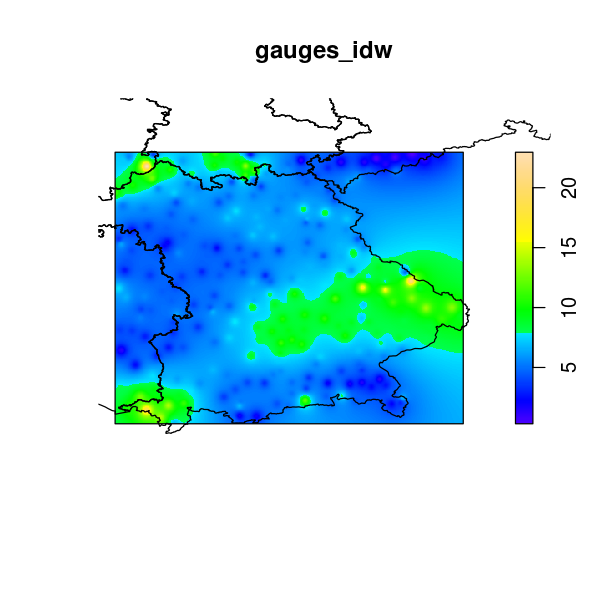

In [53]:
plot(gauges_idw)
plot(gadm_1, border='black', lwd=1, add=T)

### Check RMSE for IDW interpolation

## Kriging Interpolation

In [45]:
# Variogram and Envelope
coord_matrix <- cbind(gauges$longitude, gauges$latitude)
vg <- variog(coords=coord_matrix, 
             data=gauges$obs_precip, max.dist=3)
# Run 9999 Monte Carlo simulations
vg_envel <- variog.mc.env(coords=coord_matrix, 
                          data=gauges$obs_precip, 
                          obj.var=vg, 
                          nsim=999)

variog: computing omnidirectional variogram
variog.env: generating 999 simulations by permutating data values
variog.env: computing the empirical variogram for the 999 simulations
variog.env: computing the envelops


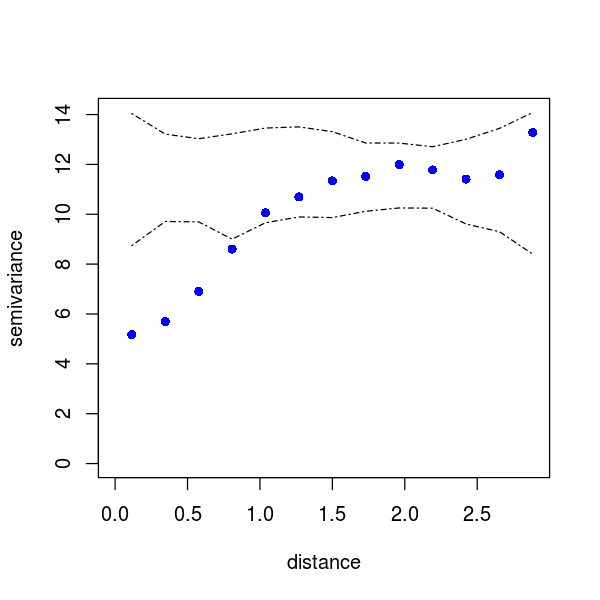

In [46]:
options(repr.plot.width=5, repr.plot.height=5)
plot(vg, envelope=vg_envel, pch=16, col="blue")

variofit: covariance model used is exponential 
variofit: weights used: npairs 
variofit: minimisation function used: optim 
variofit: covariance model used is spherical 
variofit: weights used: npairs 
variofit: minimisation function used: optim 
variofit: covariance model used is gaussian 
variofit: weights used: npairs 
variofit: minimisation function used: optim 


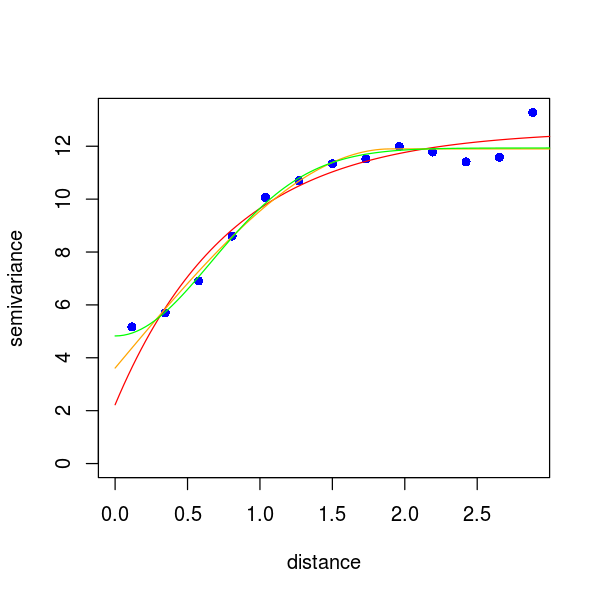

In [51]:
# Guess at nugget, sill and range
krige_params = c(11, 1.5)

plot(vg, pch=16, col="blue")
# Use three different models
vg_fit_exp <- variofit(vg, ini.cov.pars=krige_params, 
                       cov.model = "exponential",
                       fix.nugget = F, nugget = 3)
vg_fit_sph <- variofit(vg, ini.cov.pars=krige_params, 
                       cov.model = "spherical",
                       fix.nugget = F, nugget = 3)
vg_fit_gau <- variofit(vg, ini.cov.pars=krige_params, 
                       cov.model = "gaussian",
                       fix.nugget = F, nugget = 3)
lines.variomodel(vg_fit_exp, col="red")
lines.variomodel(vg_fit_sph, col="orange")
lines.variomodel(vg_fit_gau, col="green")

krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


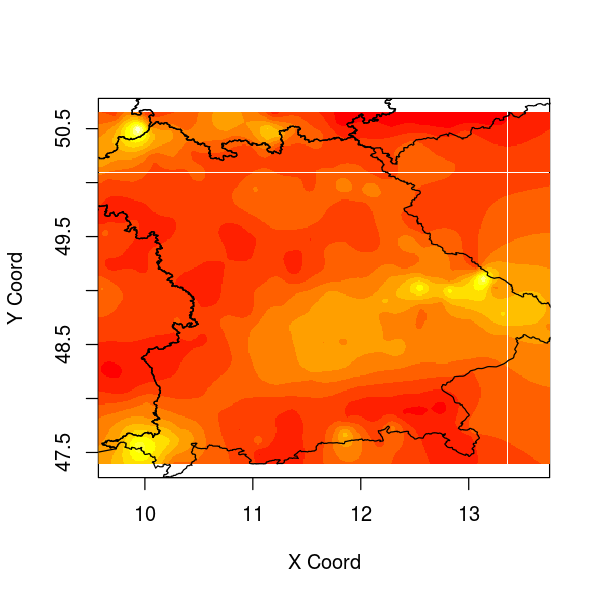

In [55]:
grd <- expand.grid(seq(minx,maxx,0.01), seq(miny,maxy,0.01))
gauges_ok <- krige.conv(coords=coord_matrix, 
                        data=gauges$obs_precip, 
                        krige = krige.control(cov.pars=krige_params), 
                        locations = grd)
image(gauges_ok)
plot(gadm_1, border='black', lwd=1, add=T)